In [1]:
%reset

In [2]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [3]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["text.usetex"] = False          # use MathText
rcParams["mathtext.fontset"] = "cm"      # Computer Modern math
rcParams["font.family"] = "serif"
from os import listdir
import os
from sbi.inference import SNPE #, prepare_for_sbi #, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm, skew, kurtosis, spearmanr
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed
from torch.optim import AdamW
from sbi.neural_nets import posterior_nn
import warnings
from sbi.inference.posteriors import DirectPosterior
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.utils import clip_grad_norm_

# torch.set_printoptions(precision=10, sci_mode=True)

%matplotlib inline

In [4]:
# Load test data set
# theta_test = torch.load('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/combined_test_thetas.pt') # thetas used for test dataset
# # DM signal
# with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/test_data_DM.pkl', 'rb') as f:
#     raw_test_DM = pickle.load(f) 
# Background signal
with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/Emulate ABC paper version 1/test_data_BG.pkl', 'rb') as f:
    data = pickle.load(f) 
# # Overall signal
# with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/combined_test_data.pkl', 'rb') as f:
#     raw_test_overall = pickle.load(f) 




# print(f"theta_test = {theta_test}")

In [5]:
print(f"Number of photons in test data = {data['energies'].size}")

Number of photons in test data = 7205742


In [6]:
energy_range = [1_000, 100_000] #MeV 
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2_000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut_degrees = 180 #degrees # 180 degress is full sky
lat_cut_degrees = 0 #degrees # 0 degrees is full sky
luminosity_range = np.array([1e13, 1e53]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.
                                            # Maximum value set by that value of luminosity that suffieciently suppreses the luminoisity function at the higher end of the luminosity range.


parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
angular_cut = angular_cut_degrees*u.deg.to('rad') # radians
angular_cut_gen =  min(angular_cut*1.5, np.pi) # radians
lat_cut = lat_cut_degrees*u.deg.to('rad') # radians
lat_cut_gen = lat_cut*0.5 # radians

In [7]:
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut , lat_cut, flux_cut, energy_range_gen=energy_range_gen, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen = angular_cut_gen, lat_cut_gen

In [8]:
center_mask = 0 #deg
lat_mask = 0 #deg 
N_Ebins = 1
# Ebinspace = 'log'#'linear'
# N_countbins = 20
# countbinspace = 'linear' #'arange' #'custom' #'linear' #using 'arange' countbinspace; if mincount=0 and maxcount=8, then counts_bin_array=[0,1,2,4,6,8] #
# mincount_2D_hist, maxcount_2D_hist = 0, 70 # CHANGE FOR DIFFERENT DATASETS. # For 10 energy bins.  # For energy-dependent 2D histogram . Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
# mincount_1D_counts_hist, maxcount_1D_counts_hist = 0, 55 # CHANGE FOR DIFFERENT DATASETS. # For counts only 1D histogram . Consider the data set with the maximum number of photons to decide the value of 'maxcount'.

N_side = 64
N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

print(f"Are pix_i and roi_pix_i the same array? {np.array_equal(pix_i, roi_pix_i)}")

# Get energy dependent 2D histogram - regular

roi_map_2D, E_bin_edges = my_AEGIS.get_roi_map_summary(photon_info = data, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
roi_map = roi_map_2D.ravel() # creates a 1D array of shape (roi_pix_i.size,) # Note that roi_map_2D.shape = (roi_pix_i.size, 1)
print(f"roi_map.shape = {roi_map.shape}")

print(roi_map.max())




Are pix_i and roi_pix_i the same array? True
roi_map.shape = (49152,)
202.0


Generate PDF of photons-in-a-pixel

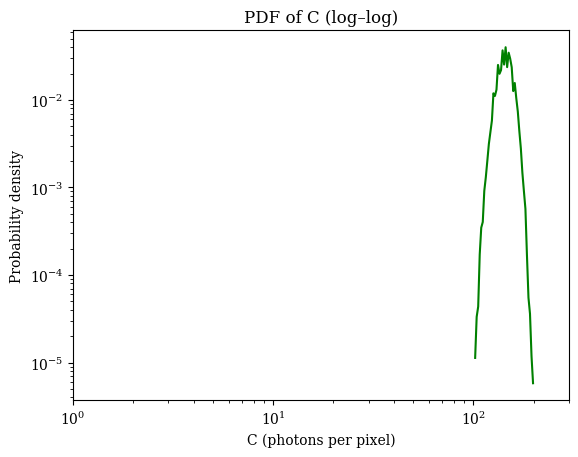

In [9]:
# roi_map contains the values of photons-in-a-pixel (C)
bin_edges = np.geomspace(roi_map.min(), roi_map.max(), 40)
pdf, edges = np.histogram(roi_map, bins=bin_edges, density=True)

plt.figure()
plt.loglog(edges[:-1], pdf, color='green')
plt.xlabel('C (photons per pixel)')
plt.ylabel('Probability density')
plt.title('PDF of C (log–log)')
plt.xlim(1, 300)
plt.show()